## **Data Load**

In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import timeit
import tracemalloc
import random

In [3]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

# x_train = x_train.astype(np.float64)
# x_test = x_test.astype(np.float64)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)


# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


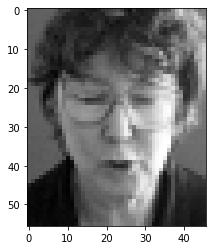

In [4]:
plt.imshow(np.reshape(x_train[:,0],(46,56)).T, cmap = 'gist_gray')

## **Q1. [10] Eigenfaces**

This is mean image


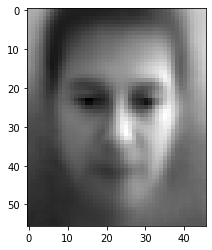

In [5]:
# Get train_mean
x_train_bar = np.average(x_train, axis=1).reshape(-1,1)

# Subtract the mean face
A = x_train - x_train_bar

# show mean image
print('This is mean image')
plt.imshow(np.reshape(x_train_bar,(46,56)).T, cmap = 'gist_gray')

1. (a)

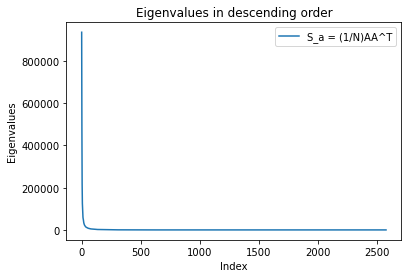

In [6]:
# S_a = (1/N)AA^T
S_a = np.matmul(A, A.T) / A.shape[1]

# S_a eigendecomposition
eigvals_a, eigvecs_a = np.linalg.eigh(S_a)

sorted_indices = np.argsort(eigvals_a)[::-1]

eigvals_a = eigvals_a[sorted_indices]
eigvecs_a = eigvecs_a[:, sorted_indices]

# Plot the arrays
plt.plot(eigvals_a, label="S_a = (1/N)AA^T")

# Add title and labels
plt.title("Eigenvalues in descending order")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")

# Add a legend to distinguish the arrays
plt.legend()

# plt.figure(figsize=(4,6))

# Show the plot
plt.show()

In [7]:
# If eigenvalue is smaller than 10^(-5) -> assume it is zero
print(f'Total number of eigenvalues {len(eigvals_a)}')
print(f'Total number of non-zero eigenvlaues: {len(eigvals_a[eigvals_a >= 0.00001])}')
print(f'Total number of zero eigenvlaues: {len(eigvals_a[eigvals_a < 0.00001])}')

Total number of eigenvalues 2576
Total number of non-zero eigenvlaues: 415
Total number of zero eigenvlaues: 2161


In [8]:
# Use the eigenvectors when eigenvalues >= max(eigenvalues) * threshold
threshold = 0.05
print(f'How many eigenvectors are to be used: {len(eigvals_a[eigvals_a >= np.max(eigvals_a) * threshold])}')

How many eigenvectors are to be used: 15


1. (b)

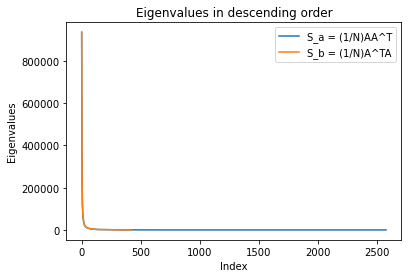

In [9]:
# S_b = (1/N)A^TA
S_b = np.matmul(A.T, A) / A.shape[1]

# S_b eigendecomposition
eigvals_b, eigvecs_b = np.linalg.eigh(S_b)

sorted_indices = np.argsort(eigvals_b)[::-1]

eigvals_b = eigvals_b[sorted_indices]
eigvecs_b = eigvecs_b[:, sorted_indices]

# Plot the arrays
plt.plot(eigvals_a, label="S_a = (1/N)AA^T")
plt.plot(eigvals_b, label="S_b = (1/N)A^TA")

# Add title and labels
plt.title("Eigenvalues in descending order")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")

# Add a legend to distinguish the arrays
plt.legend()

# Show the plot
plt.show()

In [10]:
# If eigenvalue is smaller than 10^(-5) -> assume it is zero
print(f'Total number of eigenvalues {len(eigvals_b)}')
print(f'Total number of non-zero eigenvlaues: {len(eigvals_b[eigvals_b >= 0.00001])}')
print(f'Total number of zero eigenvlaues: {len(eigvals_b[eigvals_b < 0.00001])}')

Total number of eigenvalues 416
Total number of non-zero eigenvlaues: 415
Total number of zero eigenvlaues: 1


Compare eigenvectors

In [11]:
approx_v_b = np.matmul(A.T, eigvecs_a)[:, :eigvecs_b.shape[1]]
# Normalize -> eigenvectors can be different by scaling factor
approx_v_b /= np.linalg.norm(approx_v_b, axis=0)

# sign can be different
diff1 = np.abs(approx_v_b - eigvecs_b)
diff2 = np.abs(approx_v_b + eigvecs_b)

# Select the minimum difference for sign alignment
final_diff = np.minimum(diff1, diff2)

# If difference is smaller than 10^(-5) -> assume it is zero
final_diff[final_diff<0.00001] = 0
print("Difference between transformed eigvecs_a and eigvecs_b:\n", final_diff)

Difference between transformed eigvecs_a and eigvecs_b:
 [[0.         0.         0.         ... 0.         0.         0.00716194]
 [0.         0.         0.         ... 0.         0.         0.04730853]
 [0.         0.         0.         ... 0.         0.         0.04204879]
 ...
 [0.         0.         0.         ... 0.         0.         0.01089528]
 [0.         0.         0.         ... 0.         0.         0.01570237]
 [0.         0.         0.         ... 0.         0.         0.00478211]]


## **Q1. [15] Application of Eigenfaces**

Keep the best M eigenvectors

In [12]:
M = [1, 15, 30]

# Using S_a
U_0 = eigvecs_a[:, :M[0]]
U_1 = eigvecs_a[:, :M[1]]
U_2 = eigvecs_a[:, :M[2]]

# W = U^TA
W_0 = np.matmul(U_0.T, A)
W_1 = np.matmul(U_1.T, A)
W_2 = np.matmul(U_2.T, A)

# reconstruction
x_rec_0 = x_train_bar + np.matmul(U_0, W_0)
x_rec_1 = x_train_bar + np.matmul(U_1, W_1)
x_rec_2 = x_train_bar + np.matmul(U_2, W_2)

Show reconstruction image

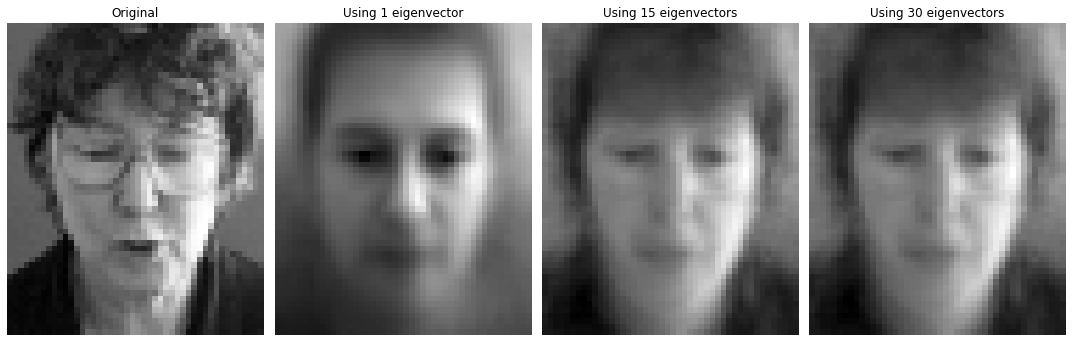

In [13]:
# Sample data for demonstration
image1 = np.reshape(x_train[:,0],(46,56)).T
image2 = np.reshape(x_rec_0[:,0],(46,56)).T
image3 = np.reshape(x_rec_1[:,0],(46,56)).T
image3 = np.reshape(x_rec_2[:,0],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(image1, cmap = 'gist_gray')
axes[0].set_title("Original")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(image2, cmap = 'gist_gray')
axes[1].set_title(f'Using {M[0]} eigenvector')
axes[1].axis('off')

axes[2].imshow(image3, cmap = 'gist_gray')
axes[2].set_title(f'Using {M[1]} eigenvectors')
axes[2].axis('off')

axes[3].imshow(image3, cmap = 'gist_gray')
axes[3].set_title(f'Using {M[2]} eigenvectors')
axes[3].axis('off')

# Show the images
plt.tight_layout()
plt.show()


Reconstruction image for Test data

In [17]:
A_test = x_test - x_train_bar

W_test_0 = np.matmul(U_0.T, A_test)
W_test_1 = np.matmul(U_1.T, A_test)
W_test_2 = np.matmul(U_2.T, A_test)

x_test_rec_0 = x_train_bar + np.matmul(U_0, W_test_0)
x_test_rec_1 = x_train_bar + np.matmul(U_1, W_test_1)
x_test_rec_2 = x_train_bar + np.matmul(U_2, W_test_2)

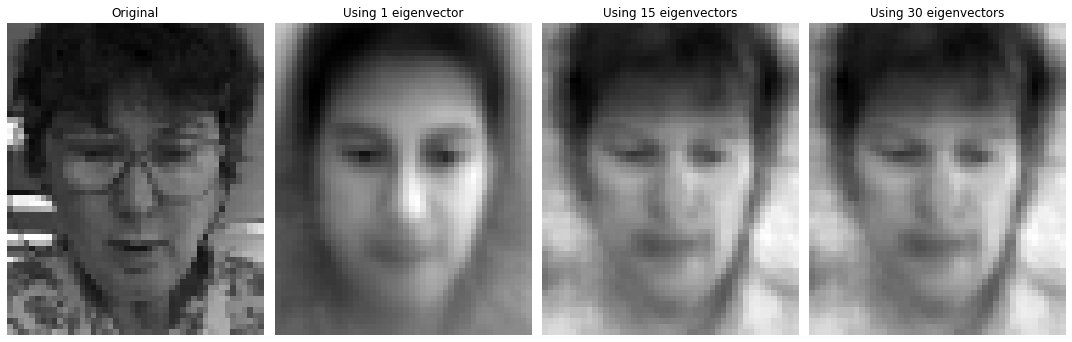

In [15]:
# Sample data for demonstration
image1 = np.reshape(x_test[:,0],(46,56)).T
image2 = np.reshape(x_test_rec_0[:,0],(46,56)).T
image3 = np.reshape(x_test_rec_1[:,0],(46,56)).T
image3 = np.reshape(x_test_rec_2[:,0],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(image1, cmap = 'gist_gray')
axes[0].set_title("Original")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(image2, cmap = 'gist_gray')
axes[1].set_title(f'Using {M[0]} eigenvector')
axes[1].axis('off')

axes[2].imshow(image3, cmap = 'gist_gray')
axes[2].set_title(f'Using {M[1]} eigenvectors')
axes[2].axis('off')

axes[3].imshow(image3, cmap = 'gist_gray')
axes[3].set_title(f'Using {M[2]} eigenvectors')
axes[3].axis('off')

# Show the images
plt.tight_layout()
plt.show()


### **Reconstruction Error**

In [16]:
rec_err_0 = np.mean(np.abs(x_train - x_rec_0))
print(f"Reconstruction Error with {M[0]} eigenvectors (MAE): {rec_err_0}")

rec_err_1 = np.mean(np.abs(x_train - x_rec_1))
print(f"Reconstruction Error with {M[1]} eigenvectors (MAE): {rec_err_1}")

rec_err_2 = np.mean(np.abs(x_train - x_rec_2))
print(f"Reconstruction Error with {M[2]} eigenvectors (MAE): {rec_err_2}")

Reconstruction Error with 1 eigenvectors (MAE): 28.2082173564267
Reconstruction Error with 15 eigenvectors (MAE): 15.61619434362437
Reconstruction Error with 30 eigenvectors (MAE): 12.605747485982162


### **1. (b) PCA based face recognition**

pca library 사용

In [58]:
def pca_nn(n_components, x_train, y_train, x_test):
  # Measure memory usage and execution time
  tracemalloc.start() 
  start_time = timeit.default_timer()

  pca = PCA(n_components = n_components)
  pca.fit(x_train.T)

  # Project train data
  W_train = pca.transform(x_train.T).T

  # Train NN model
  nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
  nn.fit(W_train.T, y_train.reshape(-1))

  # Project test data and predict
  W_test = pca.transform(x_test.T).T
  y_pred = nn.predict(W_test.T)

  current_memory, peak_memory = tracemalloc.get_traced_memory()
  tracemalloc.stop()
  end_time = timeit.default_timer()

  run_time = end_time - start_time

  return y_pred, run_time, current_memory, peak_memory

y_pred, run_time, current_memory, peak_memory = pca_nn(15, x_train, y_train, x_test)

accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy : {accuracy * 100:.2f}%")

Accuracy : 49.04%


Varying parameter values -> number of bases

In [77]:
num_base_vecs = []
y_pred_result = []
acc_result = []
runtime_result = []
cur_mem_result = []
peak_mem_result = []


for i in range(1, 21):
  num_bases = 5*i
  num_base_vecs.append(num_bases)

  y_pred, run_time, current_memory, peak_memory = pca_nn(num_bases, x_train, y_train, x_test)
  y_pred_result.append(y_pred)

  # accuracy: %
  accuracy = accuracy_score(y_test.T, y_pred) * 100
  acc_result.append(accuracy)

  # runtime -> seconds
  runtime_result.append(run_time)

  # memory -> Mega Bite (MB)
  cur_mem_result.append(current_memory / 10**6)
  peak_mem_result.append(peak_memory / 10**6)

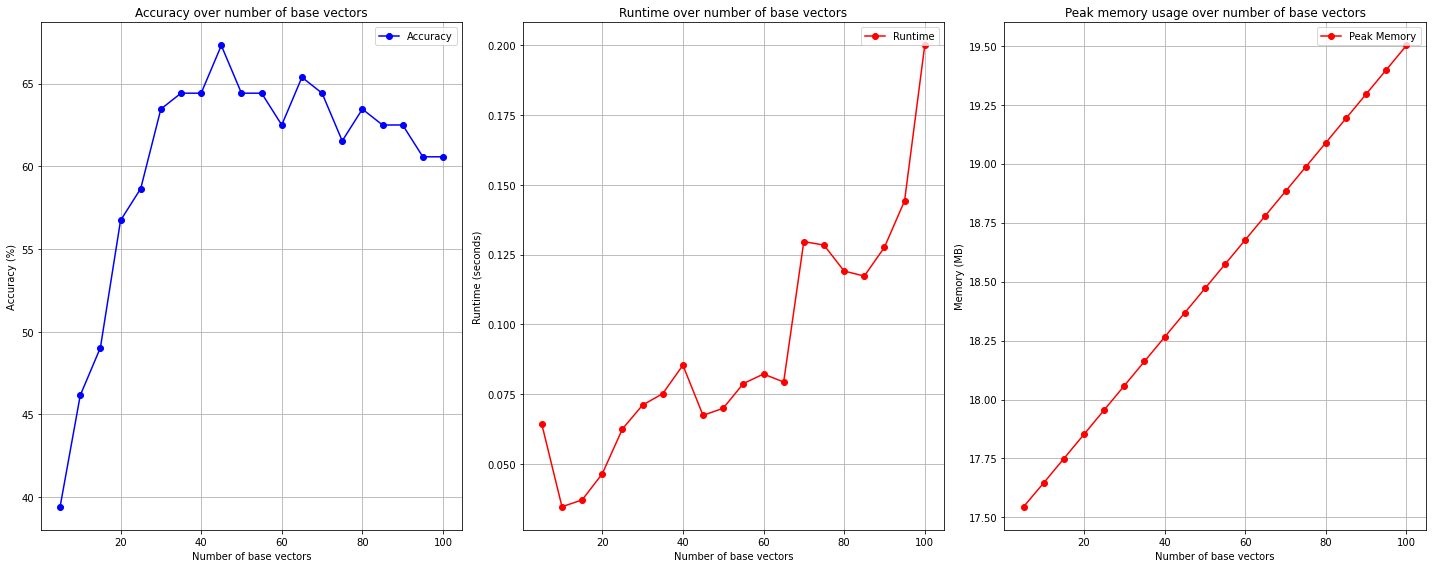

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, acc_result, marker='o', linestyle='-', color='b', label='Accuracy')
axes[0].set_xlabel('Number of base vectors')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy over number of base vectors')
axes[0].legend()
axes[0].grid(True)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, runtime_result, marker='o', linestyle='-', color='r', label='Runtime')
axes[1].set_xlabel('Number of base vectors')
axes[1].set_ylabel('Runtime (seconds)')  # Customize based on your runtime units
axes[1].set_title('Runtime over number of base vectors')
axes[1].legend()
axes[1].grid(True)

# Plot Peak memory usage on third subplot
axes[2].plot(num_base_vecs, peak_mem_result, marker='o', linestyle='-', color='r', label='Peak Memory')
axes[2].set_xlabel('Number of base vectors')
axes[2].set_ylabel('Memory (MB)')  # Customize based on your runtime units
axes[2].set_title('Peak memory usage over number of base vectors')
axes[2].legend()
axes[2].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Accuracy: 39.42%


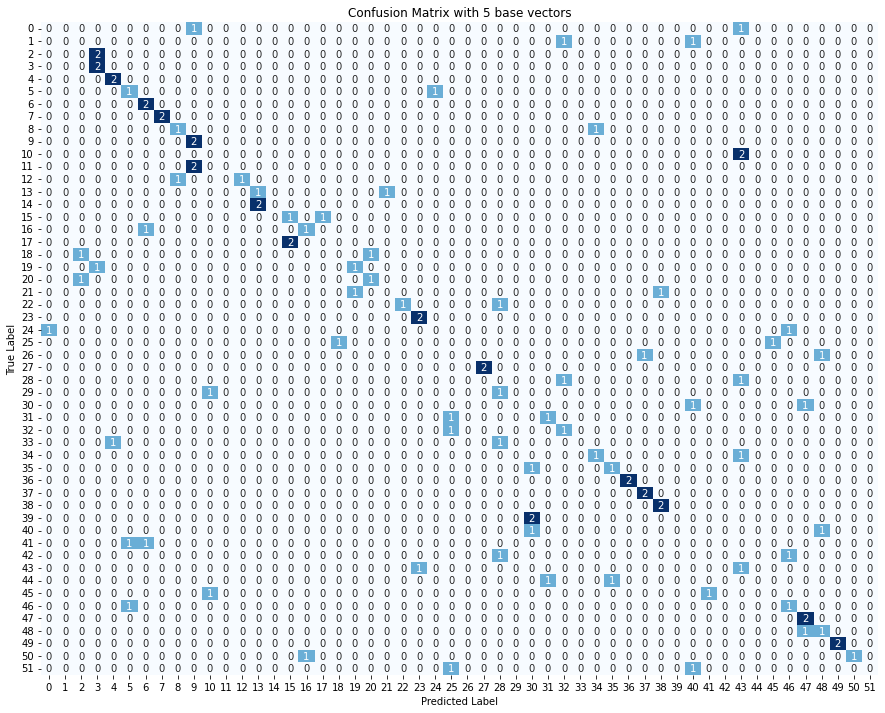

In [87]:
# confusion matrix with 5 base eigenvectors
cm0 = confusion_matrix(y_test.reshape(-1), y_pred_result[0])
print(f'Accuracy: {acc_result[0]:.2f}%')

plt.figure(figsize=(15, 12))
sns.heatmap(cm0, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix with {num_base_vecs[0]} base vectors')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 49.04%


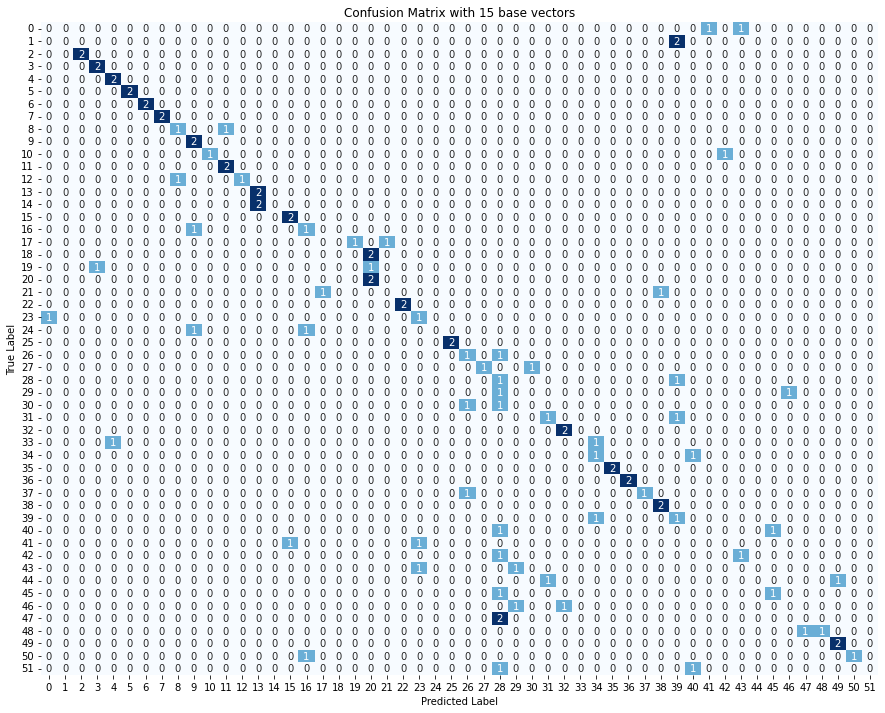

In [94]:
# confusion matrix with 15 base eigenvectors
cm1 = confusion_matrix(y_test.reshape(-1), y_pred_result[2])
print(f'Accuracy: {acc_result[2]:.2f}%')

plt.figure(figsize=(15, 12))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix with {num_base_vecs[2]} base vectors')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy: 63.46%


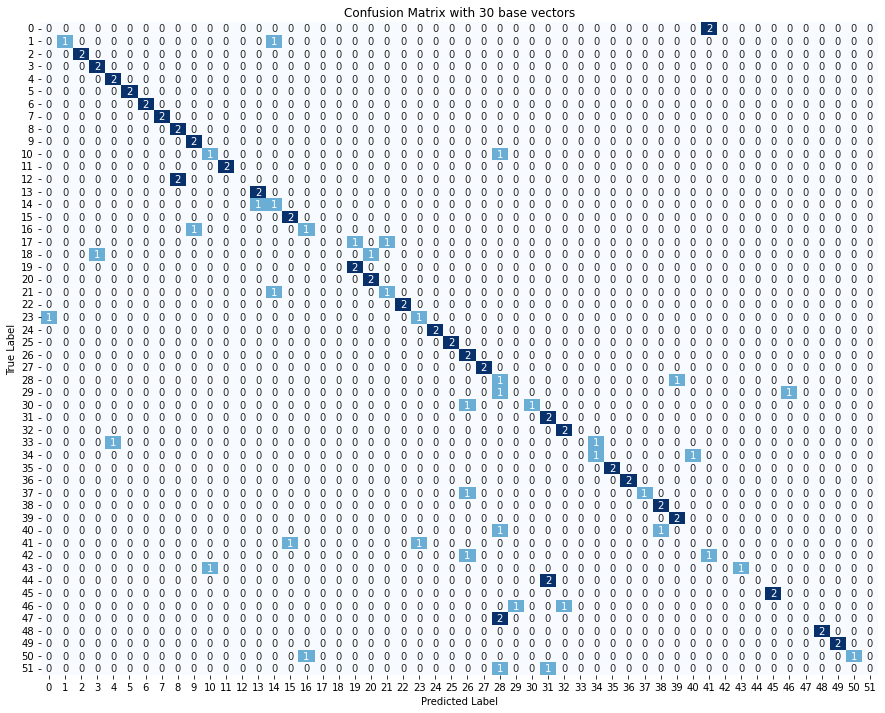

In [95]:
# confusion matrix with 30 base eigenvectors
cm2 = confusion_matrix(y_test.reshape(-1), y_pred_result[5])
print(f'Accuracy: {acc_result[5]:.2f}%')

plt.figure(figsize=(15, 12))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix with {num_base_vecs[5]} base vectors')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Example success and failure cases

In [194]:
def pca_nn_recon(n_components, x_train, y_train, x_test):
  pca = PCA(n_components = n_components)
  pca.fit(x_train.T)

  # Project train data
  W_train = pca.transform(x_train.T).T

  # Train NN model
  nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
  nn.fit(W_train.T, y_train.reshape(-1))

  # Project test data and predict
  W_test = pca.transform(x_test.T).T
  test_recon = pca.inverse_transform(W_test.T).T

  y_pred = nn.predict(W_test.T)

  return y_pred, test_recon

In [199]:
# apply pca recognition and get reconstruction images
y_pred, test_recon  = pca_nn_recon(15, x_train, y_train, x_test)

# Separate success and failure cases
suc_idx = []
suc_label = []
fail_idx = []
fail_label = []

for i in range(len(y_pred)):
  if y_test.T[i] == y_pred[i]:
    suc_idx.append(i)
    suc_label.append(y_test.T[i])
  else:
    fail_idx.append(i)
    # fail as which image
    fail_label.append(y_pred.T[i])

Success Case Images

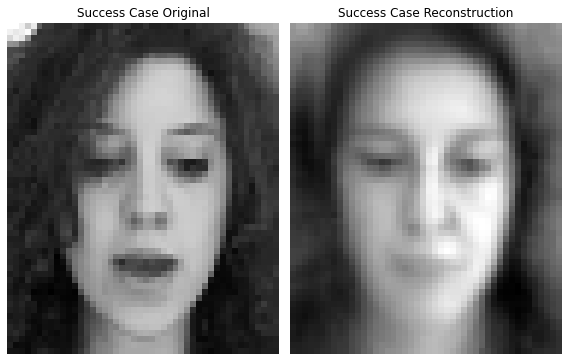

In [202]:
# Success cases
random.seed(0)
random_case = random.randint(0, len(suc_idx) - 1)

suc_origin = np.reshape(x_test[:,suc_idx[random_case]],(46,56)).T
suc_recon = np.reshape(test_recon[:,suc_idx[random_case]],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(suc_origin, cmap = 'gist_gray')
axes[0].set_title("Success Case Original")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(suc_recon, cmap = 'gist_gray')
axes[1].set_title("Success Case Reconstruction")
axes[1].axis('off')

# Show the images
plt.tight_layout()
plt.show()

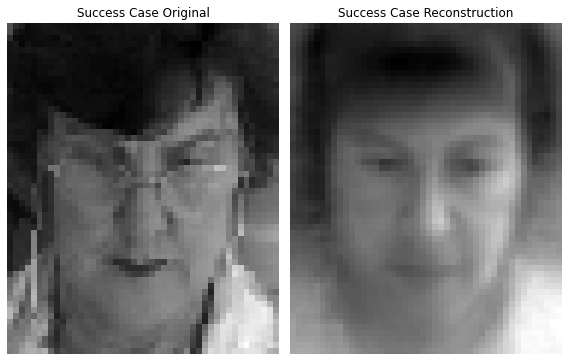

In [203]:
# Success cases
random.seed(1)
random_case = random.randint(0, len(suc_idx) - 1)

suc_origin = np.reshape(x_test[:,suc_idx[random_case]],(46,56)).T
suc_recon = np.reshape(test_recon[:,suc_idx[random_case]],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(suc_origin, cmap = 'gist_gray')
axes[0].set_title("Success Case Original")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(suc_recon, cmap = 'gist_gray')
axes[1].set_title("Success Case Reconstruction")
axes[1].axis('off')

# Show the images
plt.tight_layout()
plt.show()

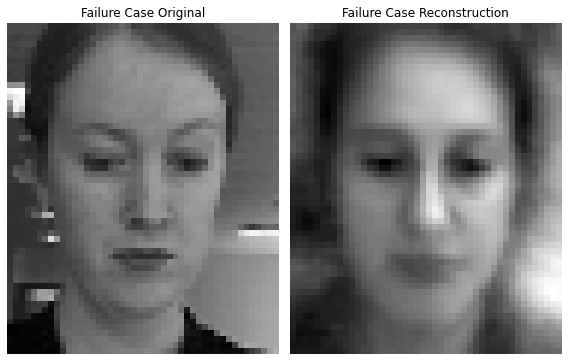

In [204]:
# Failure Cases
random.seed(2)
random_case = random.randint(0, len(fail_idx) - 1)

fail_origin = np.reshape(x_test[:,fail_idx[random_case]],(46,56)).T
fail_recon = np.reshape(test_recon[:,fail_idx[random_case]],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(fail_origin, cmap = 'gist_gray')
axes[0].set_title("Failure Case Original")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(fail_recon, cmap = 'gist_gray')
axes[1].set_title("Failure Case Reconstruction")
axes[1].axis('off')
axes[1].axis('off')

# Show the images
plt.tight_layout()
plt.show()

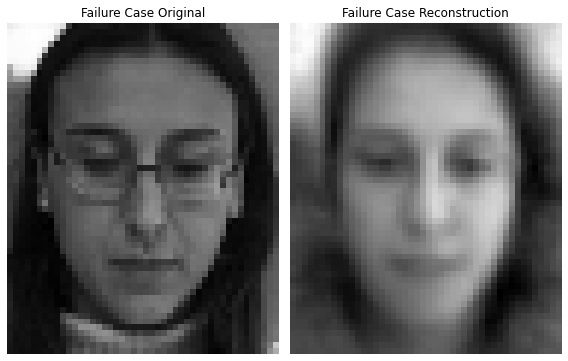

In [205]:
# Failure Cases
random.seed(3)
random_case = random.randint(0, len(fail_idx) - 1)

fail_origin = np.reshape(x_test[:,fail_idx[random_case]],(46,56)).T
fail_recon = np.reshape(test_recon[:,fail_idx[random_case]],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(fail_origin, cmap = 'gist_gray')
axes[0].set_title("Failure Case Original")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(fail_recon, cmap = 'gist_gray')
axes[1].set_title("Failure Case Reconstruction")
axes[1].axis('off')
axes[1].axis('off')

# Show the images
plt.tight_layout()
plt.show()

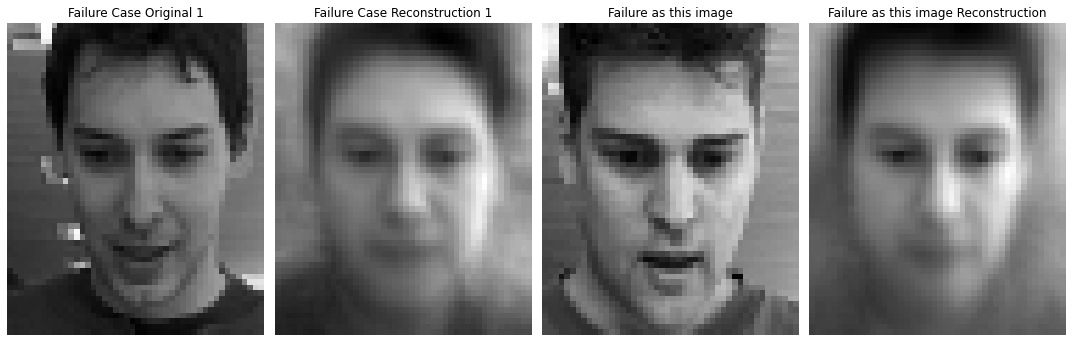

In [207]:
# Failure Cases
random.seed(0)
random_case = random.randint(0, len(fail_idx) - 1)

fail_origin1 = np.reshape(x_test[:,fail_idx[random_case]],(46,56)).T
fail_recon1 = np.reshape(test_recon[:,fail_idx[random_case]],(46,56)).T

fail_as = np.reshape(x_test[:,2*fail_label[random_case]-2],(46,56)).T
fail_as_recon = np.reshape(test_recon[:,2*fail_label[random_case]-2],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(fail_origin1, cmap = 'gist_gray')
axes[0].set_title("Failure Case Original 1")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(fail_recon1, cmap = 'gist_gray')
axes[1].set_title("Failure Case Reconstruction 1")
axes[1].axis('off')

axes[2].imshow(fail_as, cmap = 'gist_gray')
axes[2].set_title("Failure as this image")
axes[2].axis('off')

axes[3].imshow(fail_as_recon, cmap = 'gist_gray')
axes[3].set_title("Failure as this image Reconstruction")
axes[3].axis('off')

# Show the images
plt.tight_layout()
plt.show()

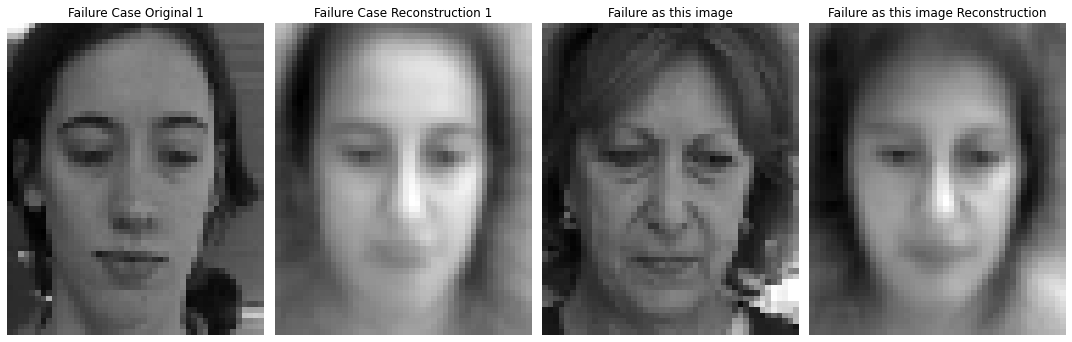

In [208]:
# Failure Cases
random.seed(1)
random_case = random.randint(0, len(fail_idx) - 1)

fail_origin1 = np.reshape(x_test[:,fail_idx[random_case]],(46,56)).T
fail_recon1 = np.reshape(test_recon[:,fail_idx[random_case]],(46,56)).T

fail_as = np.reshape(x_test[:,2*fail_label[random_case]-2],(46,56)).T
fail_as_recon = np.reshape(test_recon[:,2*fail_label[random_case]-2],(46,56)).T

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed

# Display each image in a separate subplot
axes[0].imshow(fail_origin1, cmap = 'gist_gray')
axes[0].set_title("Failure Case Original 1")
axes[0].axis('off')  # Hide axes if preferred

axes[1].imshow(fail_recon1, cmap = 'gist_gray')
axes[1].set_title("Failure Case Reconstruction 1")
axes[1].axis('off')

axes[2].imshow(fail_as, cmap = 'gist_gray')
axes[2].set_title("Failure as this image")
axes[2].axis('off')

axes[3].imshow(fail_as_recon, cmap = 'gist_gray')
axes[3].set_title("Failure as this image Reconstruction")
axes[3].axis('off')

# Show the images
plt.tight_layout()
plt.show()